# Modeling 30-Day Readmissions for Diabetics

## Overview
Medicare, Medicade and many private payers either reduce payments, or do not pay, for patient readmissions within 30 days of a discharge.  It would be very useful to be able to predict which of these patients was likely to be readmitted within 30 days.  In this example, DataRobot will try to model whether a patient will be readmitted, based on information available at the time of discharge.

## Prerequisites
In order to run this notebook yourself, you will need the following:

- This notebook. If you are viewing this in the HTML documentation bundle, you can download all of the example notebooks and supporting materials from [Downloads](../index.rst).
- The datasets required for this notebook. These are in the same directory as this notebook.
- A DataRobot API token. You can find your API token by logging into the DataRobot Web User Interface and looking in your `Profile`.

## Set Up
This example assumes that the DataRobot Python client package has been installed and configured with the credentials of a DataRobot user with API access permissions.

## Data Sources
Data is from a study of diabetic patients who were admitted to hospital and is available at https://www.hindawi.com/journals/bmri/2014/781670/sup/.  To narrow down the amount of data involved, the dataset assembled is a 20,000 row random sample of the original data.  A patientient was flagged as readmitted if they returned to the hospital and were addmitted within 30 days of the previous discharge.

## Dataset Structure
Each row in the assembled dataset contains the following columns

    - Encounter ID
        - Numeric
        - Unique identifier of an encounter       
    - Patient number
        - Numeric
        - Unique identifier of a patient       
    - Race
        - Nominal
        - Values: Caucasian, Asian, African American, Hispanic, and other      
    - Gender
        - Nominal
        - Values: male, female and unknown      
    - Age
        - Nominal
        - Grouped in 10-year intervals: [0, 10), [10, 20), ..., [90, 100)    
    - Weight
        - Nominal
        - Weight in pounds  
    - Admission type
        - Nominal
        - Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn,                     and not available        
    - Discharge disposition
        - Nominal
        - Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not                     available
    - Admission source
        - Nominal
        - Integer identifier corresponding to 21 distinct values, for example, physician referral, emergency room,             and transfer from a hospital
    - Time in hospital
        - Numeric
        - Integer number of days between admission and discharge
    - Payer code
        - Nominal
        - Integer identifier corresponding to 23 distinct values, for example, Blue Cross Blue Shield, Medicare,
          and self-pay
    - Medical specialty
        - Nominal
        - Integer identifier of a specialty of the admitting physician, corresponding to 84 distinct values, for               example, cardiology, internal medicine, family\general practice, and surgeon
    - Number of lab procedures
        - Numeric
        - Number of lab tests performed during the encounter
    - Number of procedures
        - Numeric
        - Number of procedures (other than lab tests) performed during the encounter
    - Number of medications
        - Numeric
        - Number of distinct generic names administered during the encounter
    - Number of outpatient visits
        - Numeric
        - Number of outpatient visits of the patient in the year preceding the encounter
    - Number of emergency visits
        - Numeric
        - Number of emergency visits of the patient in the year preceding the encounter
    - Number of inpatient visits
        - Numeric
        - Number of inpatient visits of the patient in the year preceding the encounter
    - Diagnosis 1
        - Nominal
        - The primary diagnosis (coded as first three digits of ICD9); 848 distinct values
    - Diagnosis 2
        - Nominal
        - Secondary diagnosis (coded as first three digits of ICD9); 923 distinct values
    - Diagnosis 3
        - Nominal
        - Additional secondary diagnosis (coded as first three digits of ICD9); 954 distinct values
    - Number of diagnoses
        - Numeric
        - Number of diagnoses entered to the system
    - Glucose serum test result
        - Nominal
        - Indicates the range of the result or if the test was not taken. Values: “>200”, “>300”, “normal” and                 “none” if not measured
    - A1c test result
        - Nominal
        - Indicates the range of the result or if the test was not taken. Values: “>8” if the result was greater 
          than 8%, “>7” if the result was greater than 7% but less than 8%, “normal” if the result was less than
          7%, and “none” if not measured.
    - Change of medications
        - Nominal
        - Indicates if there was a change in diabetic medications (either dosage or generic name). Values: “change”             and “no change”
    - Diabetes medications
        - Nominal
        - Indicates if there was any diabetic medication prescribed. Values: \“yes\” and \“no\”
    - 24 features for medications
        - Nominal
        - For the generic names: metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide,               glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone,                     tolazamide, examide, sitagliptin, insulin, glyburide-metformin, glipizide-metformin, glimepiride-                     pioglitazone, metformin-rosiglitazone, and metformin-pioglitazone, the feature indicates whether the drug             was prescribed or there was a change in the dosage. Values: “up” if the dosage was increased during the               encounter, “down” if the dosage was decreased, “steady” if the dosage did not change, and “no” if the drug           was not prescribed
    - Readmitted
        - Boolean
        - Days to inpatient readmission. Values: “TRUE” if the patient was readmitted in more than 30 days, and                 "FALSE” for no record of readmission.,
    - admit_description
        - Nominal
        - Admition source description.
    - admit_type_description
        - Nominal
        - Admition type description.
    - discharge_description
        - Nominal
        - discharge disposition description.
    - diag_1_desc
        - Nominal
        - diagnosis code 1 description.
    - diag_2_desc
        - Nominal
        - diagnosis code 2 description.
    - diag_3_desc
        - Nominal
        - diagnosis code 3 description.\n![image.png](attachment:image.png)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import pandas as pd
import datarobot as dr

from functools import reduce

In [2]:
data_path = "/Users/julius.king/Sample Data/781670.f1/Readmission_Sample.csv"
Readmission = pd.read_csv(data_path, encoding ='latin')
Readmission.head()

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,metformin-pioglitazone,change,diabetesMed,readmitted,admit_description,admit_type_description,discharge_description,diag_1_desc,diag_2_desc,diag_3_desc
0,Caucasian,Female,[70-80),?,6,25,7,2,?,InternalMedicine,...,No,No,No,False,Emergency Room,NaN,Not Mapped,Chronic passive congestion of liver,Acute pancreatitis,Adrenal cortical steroids causing adverse effe...
1,Caucasian,Female,[60-70),?,1,1,7,4,BC,?,...,No,No,Yes,False,Emergency Room,Emergency,Discharged to home,Coronary atherosclerosis of unspecified type o...,Diabetes mellitus without mention of complicat...,Malignant essential hypertension
2,AfricanAmerican,Female,[70-80),?,1,5,7,7,?,Nephrology,...,No,No,Yes,False,Emergency Room,Emergency,Discharged/transferred to another type of inpa...,"Respiratory abnormality, unspecified",Hyperosmolality and/or hypernatremia,Mitral valve stenosis and aortic valve stenosis
3,Caucasian,Female,[30-40),?,1,1,7,2,MC,?,...,No,Ch,Yes,False,Emergency Room,Emergency,Discharged to home,"Diabetes with ketoacidosis, type I [juvenile t...","Diabetes with ophthalmic manifestations, type ...",NaN
4,AfricanAmerican,Male,[60-70),?,6,6,17,5,?,Orthopedics-Reconstructive,...,No,No,Yes,False,NaN,NaN,Discharged/transferred to home with home healt...,"Closed dislocation of wrist, unspecified part",NaN,"Hypertensive chronic kidney disease, malignant..."


Based on the description of Discharge disposition, we would want to exclude \"Expired\" individuals from our analysis, so let's take a look at that field and it's corresponding description field:

In [3]:
discharges = Readmission.groupby(['discharge_description', 'discharge_disposition_id'])
for p in discharges.groups:
    print(len(discharges.groups[p]), " entries for ", p)

202  entries for  ('Not Mapped', 25)
12473  entries for  ('Discharged to home', 1)
259  entries for  ('Discharged/transferred to another type of inpatient care institution', 5)
2672  entries for  ('Discharged/transferred to home with home health service', 6)
744  entries for  (nan, 18)
434  entries for  ('Discharged/transferred to another short term hospital', 2)
158  entries for  ('Discharged/transferred to ICF', 4)
2880  entries for  ('Discharged/transferred to SNF', 3)
67  entries for  ('Hospice / home', 13)
411  entries for  ('Discharged/transferred to another rehab fac including rehab units of a hospital .', 22)
336  entries for  ('Expired', 11)
117  entries for  ('Left AMA', 7)
33  entries for  ('Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital', 28)
25  entries for  ('Discharged/transferred to home under care of Home IV provider', 8)
81  entries for  ('Discharged/transferred to a long term care hospital.', 23)
1  entries f

So, we should remove discharge ID's 11 and 19

In [4]:
Readmission_filtered = Readmission.query('discharge_disposition_id not in [11, 19]')

## DataRobot Modeling
As part of this use case, in `model_readmissions.py`, a DataRobot project will be created and used to run a variety of models against the assembled dataset.  By default, DataRobot will run autopilot on the automatically generated Informative Features list, which excludes certain pathological features (like Carrier Code in this example, which is always the same value), and we will also create a custom feature list excluding the amount of rainfall on the day of the flight.

This notebook shows how to use the Python API client to create a project, create feature lists, train models with different sample percents and feature lists, and view the models that have been run. It will:

  - create a project
  - create a new feature list
  - set the target to `readmitted`, and run DataRobot autopilot on the Informative Features list
  - rerun autopilot on a new feature list
  - make predictions on a new data set

## Configure the Python Client
Configuring the client requires the following two things:

- A DataRobot endpoint - where the API server can be found
- A DataRobot API token - a token the server uses to identify and validate the user making API requests

The endpoint is usually the URL you would use to log into the DataRobot Web User Interface (e.g., https://app.datarobot.com) with "/api/v2/" appended, e.g., (https://app.datarobot.com/api/v2/).

You can find your API token by logging into the DataRobot Web User Interface and looking in your `Profile.`

The Python client can be configured in several ways. The example we'll use in this notebook is to point to a `yaml` file that has the information. This is a text file containing two lines like this:
```yaml
endpoint: https://app.datarobot.com/api/v2/
token: not-my-real-token
```

If you want to run this notebook without changes, please save your configuration in a file located under your home directory called `~/.config/datarobot/drconfig.yaml`.

In [5]:
# Initialization with arguments
dr.Client(token='', endpoint='https://app.datarobot.com/api/v2/')

## Starting a Project

In [6]:
project = dr.Project.start(Readmission_filtered,
                           project_name='30-Day Diabetic Readmissions',
                           target="readmitted")
print('Project ID: {}'.format(project.id))

Project ID: 5d0b794580a477212d1ef727


## Jobs and the Project Queue

You can view the project in your browser:

In [30]:
#  If running notebook remotely
project.open_leaderboard_browser()

True

In [7]:
#  Set worker count higher.
#  Passing -1 sets it to the maximum available to your account.
project.set_worker_count(-1)

Project(30-Day Diabetic Readmissions)

In [8]:
project.pause_autopilot()

True

In [9]:
#  More jobs will go in the queue in each stage of autopilot.
#  This gets the currently inprogress and queued jobs
project.get_model_jobs()

[ModelJob(Breiman and Cutler Random Forest Classifier, status=inprogress),
 ModelJob(Elastic-Net Classifier (L2 / Binomial Deviance), status=inprogress),
 ModelJob(TensorFlow Neural Network Classifier, status=inprogress),
 ModelJob(eXtreme Gradient Boosted Trees Classifier with Early Stopping, status=inprogress),
 ModelJob(Elastic-Net Classifier (L2 / Binomial Deviance), status=inprogress),
 ModelJob(Nystroem Kernel SVM Classifier, status=inprogress),
 ModelJob(RandomForest Classifier (Gini), status=inprogress),
 ModelJob(Generalized Additive2 Model, status=inprogress),
 ModelJob(Light Gradient Boosted Trees Classifier with Early Stopping, status=inprogress),
 ModelJob(Light Gradient Boosting on ElasticNet Predictions , status=inprogress),
 ModelJob(Regularized Logistic Regression (L2), status=inprogress),
 ModelJob(Elastic-Net Classifier (L2 / Binomial Deviance) with Binned numeric features, status=inprogress),
 ModelJob(Elastic-Net Classifier (mixing alpha=0.5 / Binomial Deviance), s

In [10]:
project.unpause_autopilot()

True

## Features

In [11]:
features = project.get_features()
features

[Feature(metformin_rosiglitazone),
 Feature(admission_type_id),
 Feature(diabetesMed),
 Feature(chlorpropamide),
 Feature(weight),
 Feature(admit_type_description),
 Feature(repaglinide),
 Feature(payer_code),
 Feature(number_diagnoses),
 Feature(diag_3_desc),
 Feature(diag_1_desc),
 Feature(num_medications),
 Feature(readmitted),
 Feature(rosiglitazone),
 Feature(pioglitazone),
 Feature(diag_2_desc),
 Feature(tolazamide),
 Feature(discharge_disposition_id),
 Feature(citoglipton),
 Feature(admission_source_id),
 Feature(discharge_description),
 Feature(nateglinide),
 Feature(num_lab_procedures),
 Feature(glyburide),
 Feature(metformin),
 Feature(admit_description),
 Feature(tolbutamide),
 Feature(miglitol),
 Feature(time_in_hospital),
 Feature(A1Cresult),
 Feature(glyburide_metformin),
 Feature(troglitazone),
 Feature(max_glu_serum),
 Feature(acarbose),
 Feature(number_inpatient),
 Feature(acetohexamide),
 Feature(change),
 Feature(metformin_pioglitazone),
 Feature(number_emergency),
 

In [12]:
pd.DataFrame([f.__dict__ for f in features])

,date_format,feature_type,id,importance,low_information,max,mean,median,min,na_count,name,project_id,std_dev,target_leakage,time_series_eligibility_reason,time_series_eligible,time_step,time_unit,unique_count
0,None,Categorical,43,NaN,True,NaN,NaN,NaN,NaN,0,metformin_rosiglitazone,5d0b794580a477212d1ef727,NaN,SKIPPED_DETECTION,notADate,False,None,None,1
1,None,Numeric,4,0.000008,True,8.0,2.0220,1.0,1.0,0,admission_type_id,5d0b794580a477212d1ef727,1.440,FALSE,notADate,False,None,None,7
2,None,Categorical,46,0.000349,True,NaN,NaN,NaN,NaN,0,diabetesMed,5d0b794580a477212d1ef727,NaN,FALSE,notADate,False,None,None,2
3,None,Categorical,25,NaN,True,NaN,NaN,NaN,NaN,0,chlorpropamide,5d0b794580a477212d1ef727,NaN,SKIPPED_DETECTION,notADate,False,None,None,3
4,None,Categorical,3,-0.000127,True,NaN,NaN,NaN,NaN,16032,weight,5d0b794580a477212d1ef727,NaN,FALSE,notADate,False,None,None,8
5,None,Categorical,49,-0.000846,True,NaN,NaN,NaN,NaN,868,admit_type_description,5d0b794580a477212d1ef727,NaN,FALSE,notADate,False,None,None,6
6,None,Categorical,23,0.000022,True,NaN,NaN,NaN,NaN,0,repaglinide,5d0b794580a477212d1ef727,NaN,FALSE,notADate,False,None,None,4
7,None,Categorical,8,0.000561,True,NaN,NaN,NaN,NaN,6479,payer_code,5d0b794580a477212d1ef727,NaN,FALSE,notADate,False,None,None,17
8,None,Numeric,19,0.002400,True,16.0,7.4400,8.0,1.0,0,number_diagnoses,5d0b794580a477212d1ef727,1.920,FALSE,notADate,False,None,None,16
9,None,Text,53,0.001870,False,NaN,NaN,NaN,NaN,1777,diag_3_desc,5d0b794580a477212d1ef727,NaN,SKIPPED_DETECTION,notADate,False,None,None,507


Three feature lists are automatically created:

- _Raw Features_: one for all features
- _Informative Features_: one based on features with any information (columns with no variation are excluded)
- _Univariate Importance_: one based on univariate importance (this is only created after the target is set)

_Informative Features_ is the one used by default in autopilot.

In [13]:
feature_lists = project.get_featurelists()
feature_lists

[Featurelist(Raw Features),
 Featurelist(Informative Features),
 Featurelist(Univariate Selections),
 Featurelist(DR Reduced Features M69)]

In [14]:
# create a featurelist without race
# (since it could be sensitive)
informative_feats = [lst for lst in feature_lists if
                     lst.name == 'Informative Features'][0]
no_race_features = list(
    set(informative_feats.features) - {'race'})

In [15]:
no_race = project.create_featurelist('no race',
                                              no_race_features)
no_race

Featurelist(no race)

In [16]:
project.get_status()

{'autopilot_done': False,
 'stage_description': 'Ready for modeling',
 'stage': 'modeling'}

In [17]:
# This waits until autopilot is complete:
project.wait_for_autopilot(check_interval=90)

In progress: 4, queued: 0 (waited: 0s)
In progress: 4, queued: 0 (waited: 0s)
In progress: 4, queued: 0 (waited: 1s)
In progress: 4, queued: 0 (waited: 2s)
In progress: 4, queued: 0 (waited: 3s)
In progress: 4, queued: 0 (waited: 5s)
In progress: 4, queued: 0 (waited: 8s)
In progress: 3, queued: 0 (waited: 15s)
In progress: 1, queued: 0 (waited: 29s)
In progress: 0, queued: 0 (waited: 55s)


In [18]:
project.start_autopilot(no_race.id)

In [19]:
project.wait_for_autopilot(check_interval=90)

In progress: 20, queued: 19 (waited: 0s)
In progress: 20, queued: 19 (waited: 1s)
In progress: 20, queued: 19 (waited: 1s)
In progress: 20, queued: 19 (waited: 2s)
In progress: 20, queued: 19 (waited: 3s)
In progress: 20, queued: 19 (waited: 6s)
In progress: 20, queued: 19 (waited: 9s)
In progress: 19, queued: 19 (waited: 16s)
In progress: 20, queued: 15 (waited: 30s)
In progress: 20, queued: 0 (waited: 56s)
In progress: 2, queued: 0 (waited: 107s)
In progress: 2, queued: 0 (waited: 198s)
In progress: 1, queued: 0 (waited: 288s)
In progress: 20, queued: 12 (waited: 379s)
In progress: 0, queued: 0 (waited: 469s)
In progress: 1, queued: 0 (waited: 560s)
In progress: 2, queued: 0 (waited: 650s)
In progress: 0, queued: 0 (waited: 741s)


## Models

In [20]:
models = project.get_models()
example_model = models[0]
example_model

Model('AVG Blender')

Models represent fitted models and have various data about the model, including metrics:

In [21]:
example_model.metrics

{'AUC': {'backtesting': None,
  'holdout': None,
  'backtestingScores': None,
  'crossValidation': 0.663762,
  'validation': 0.64237},
 'Rate@Top5%': {'backtesting': None,
  'holdout': None,
  'backtestingScores': None,
  'crossValidation': 0.32168599999999997,
  'validation': 0.33133},
 'RMSE': {'backtesting': None,
  'holdout': None,
  'backtestingScores': None,
  'crossValidation': 0.313722,
  'validation': 0.31479},
 'Kolmogorov-Smirnov': {'backtesting': None,
  'holdout': None,
  'backtestingScores': None,
  'crossValidation': 0.25822599999999996,
  'validation': 0.21996},
 'Rate@TopTenth%': {'backtesting': None,
  'holdout': None,
  'backtestingScores': None,
  'crossValidation': 0.55,
  'validation': 0.75},
 'LogLoss': {'backtesting': None,
  'holdout': None,
  'backtestingScores': None,
  'crossValidation': 0.341086,
  'validation': 0.34419},
 'FVE Binomial': {'backtesting': None,
  'holdout': None,
  'backtestingScores': None,
  'crossValidation': 0.050398,
  'validation': 0.0

In [22]:
def sorted_by_log_loss(models, test_set):
    models_with_score = [model for model in models if
                         model.metrics['LogLoss'][test_set] is not None]
    return sorted(models_with_score,
                  key=lambda model: model.metrics['LogLoss'][test_set])

Let's choose the models (from each feature set, to compare the scores) with the best LogLoss score from those with race and those without:

In [23]:
models = project.get_models()
models_wo_race = [mod for mod in models if
               mod.featurelist_id == no_race.id]
models_w_race = [mod for mod in models if
                     mod.featurelist_id == informative_feats.id]

In [24]:
best_wo_race_model = sorted_by_log_loss(models_wo_race, 'crossValidation')[0]
best_w_race_model = sorted_by_log_loss(models_w_race, 'crossValidation')[0]
best_wo_race_model, best_wo_race_model.metrics, best_w_race_model, best_w_race_model.metrics

(Model('Generalized Additive2 Model'),
 {'AUC': {'backtesting': None,
   'holdout': None,
   'backtestingScores': None,
   'crossValidation': 0.659998,
   'validation': 0.63964},
  'Rate@Top5%': {'backtesting': None,
   'holdout': None,
   'backtestingScores': None,
   'crossValidation': 0.307228,
   'validation': 0.3253},
  'RMSE': {'backtesting': None,
   'holdout': None,
   'backtestingScores': None,
   'crossValidation': 0.31425200000000003,
   'validation': 0.31522},
  'Kolmogorov-Smirnov': {'backtesting': None,
   'holdout': None,
   'backtestingScores': None,
   'crossValidation': 0.24781,
   'validation': 0.20861},
  'Rate@TopTenth%': {'backtesting': None,
   'holdout': None,
   'backtestingScores': None,
   'crossValidation': 0.45,
   'validation': 0.25},
  'LogLoss': {'backtesting': None,
   'holdout': None,
   'backtestingScores': None,
   'crossValidation': 0.34214399999999995,
   'validation': 0.34501},
  'FVE Binomial': {'backtesting': None,
   'holdout': None,
   'backte

Top models are Generalized Additive models, we'll use the one with race

In [25]:
best_w_race_model = sorted_by_log_loss(models_w_race, 'crossValidation')[0]
best_w_race_model.model_type

'Generalized Additive2 Model'

## Visualizing Models

Example from:
https://datarobot-public-api-client.readthedocs-hosted.com/en/v2.16.0/examples/advanced_model_insights/Advanced_Model_Insights.html

In [26]:
feature_impacts = best_w_race_model.get_or_request_feature_impact()

In [27]:
dr_dark_blue = '#08233F'
dr_blue = '#1F77B4'
dr_orange = '#FF7F0E'
dr_red = '#BE3C28'

Text(0.5, 1.04, 'Feature Impact')

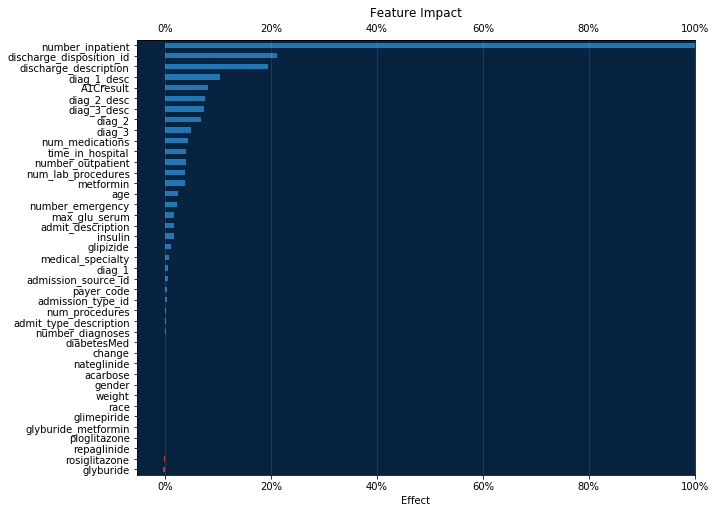

In [28]:
# Formats the ticks from a float into a percent
percent_tick_fmt = mtick.PercentFormatter(xmax=1.0)

impact_df = pd.DataFrame(feature_impacts)
impact_df.sort_values(by='impactNormalized', ascending=True, inplace=True)

# Positive values are blue, negative are red
bar_colors = impact_df.impactNormalized.apply(lambda x: dr_red if x < 0
                                              else dr_blue)

ax = impact_df.plot.barh(x='featureName', y='impactNormalized',
                         legend=False,
                         color=bar_colors,
                         figsize=(10, 8))
ax.xaxis.set_major_formatter(percent_tick_fmt)
ax.xaxis.set_tick_params(labeltop=True)
ax.xaxis.grid(True, alpha=0.2)
ax.set_facecolor(dr_dark_blue)

plt.ylabel('')
plt.xlabel('Effect')
plt.xlim((None, 1))  # Allow for negative impact
plt.title('Feature Impact', y=1.04)

## Average many model impacts

In [29]:
def get_impact_as_df(model):
    impact_df = pd.DataFrame(model.get_or_request_feature_impact())
    impact_df['model_name'] = model.model_type
    return(impact_df)

In [30]:
n = 5
top_n_models = sorted_by_log_loss(models_w_race, 'crossValidation')[4:n+4]
top_impacts = [get_impact_as_df(model) for model in top_n_models]
impact_df = pd.concat(top_impacts)

In [31]:
impact_df = impact_df.groupby('featureName', as_index=False)['impactNormalized'].mean()

Text(0.5, 1.04, 'Feature Impact')

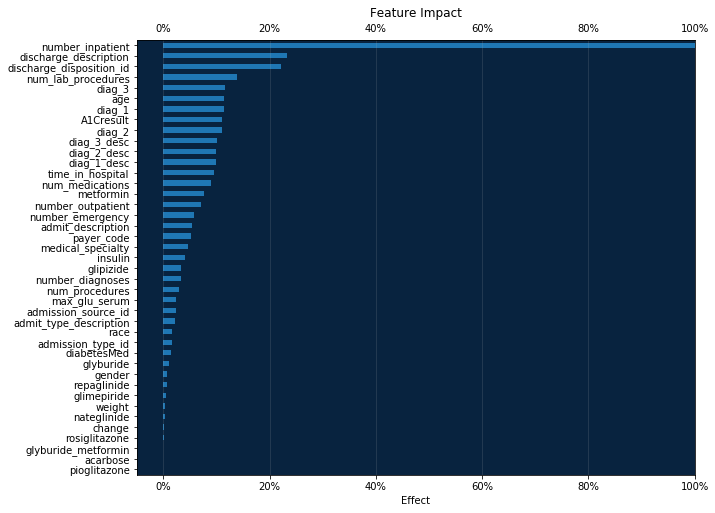

In [32]:
# Formats the ticks from a float into a percent
percent_tick_fmt = mtick.PercentFormatter(xmax=1.0)

impact_df.sort_values(by='impactNormalized', ascending=True, inplace=True)

# Positive values are blue, negative are red
bar_colors = impact_df.impactNormalized.apply(lambda x: dr_red if x < 0
                                              else dr_blue)

ax = impact_df.plot.barh(x='featureName', y='impactNormalized',
                         legend=False,
                         color=bar_colors,
                         figsize=(10, 8))
ax.xaxis.set_major_formatter(percent_tick_fmt)
ax.xaxis.set_tick_params(labeltop=True)
ax.xaxis.grid(True, alpha=0.2)
ax.set_facecolor(dr_dark_blue)

plt.ylabel('')
plt.xlabel('Effect')
plt.xlim((None, 1))  # Allow for negative impact
plt.title('Feature Impact', y=1.04)

## Unlocking the Holdout

To maintain holdout scores as a valid estimate of out-of-sample error, we recommend not looking at them until late in the project. For this reason, holdout scores are locked until you unlock them.

In [33]:
project.unlock_holdout()

Project(30-Day Diabetic Readmissions)

In [34]:
best_wo_race_model = dr.Model.get(project.id, best_wo_race_model.id)
best_w_race_model = dr.Model.get(project.id, best_w_race_model.id)

In [35]:
best_wo_race_model, best_wo_race_model.metrics['LogLoss'], best_w_race_model, best_w_race_model.metrics['LogLoss']

(Model('Generalized Additive2 Model'),
 {'backtesting': None,
  'holdout': 0.3357,
  'backtestingScores': None,
  'crossValidation': 0.34214399999999995,
  'validation': 0.34501},
 Model('Generalized Additive2 Model'),
 {'backtesting': None,
  'holdout': 0.33637,
  'backtestingScores': None,
  'crossValidation': 0.342392,
  'validation': 0.34573})

## Retrain on 100%

When ready to use the final model, you will probably get the best performance by retraining on 100% of the data.

In [36]:
model_job_w_race_100pct_id = best_w_race_model.train(sample_pct=100)
model_job_w_race_100pct_id

'277'

Wait for the model to complete:

In [37]:
model_w_race_100pct = dr.models.modeljob.wait_for_async_model_creation(
    project.id, model_job_w_race_100pct_id)
model_w_race_100pct.id

'5d0b880c80a47722241ef7cf'

## Predictions

Let's make predictions for some new data. This new data will need to have the same transformations applied as we applied to the training data.

In [38]:
scoring_df = pd.read_csv("/Users/julius.king/Sample Data/781670.f1/Scoring_Sample.csv", encoding ='latin')
scoring_modeling = scoring_df.query('discharge_disposition_id not in [11, 19]')
scoring_modeling.head()

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,metformin-pioglitazone,change,diabetesMed,readmitted,admit_description,admit_type_description,discharge_description,diag_1_desc,diag_2_desc,diag_3_desc
0,Caucasian,Female,[40-50),?,2,3,4,5,MD,?,...,No,Ch,Yes,False,Transfer from a hospital,Urgent,Discharged/transferred to SNF,Pulmonary collapse,NaN,"Obesity, unspecified"
1,Caucasian,Male,[70-80),?,1,6,7,3,HM,?,...,No,No,Yes,False,Emergency Room,Emergency,Discharged/transferred to home with home healt...,Allergic purpura,"Multiple myeloma, without mention of having ac...",Paroxysmal supraventricular tachycardia
2,Caucasian,Male,[50-60),?,1,1,7,6,MC,?,...,No,Ch,Yes,False,Emergency Room,Emergency,Discharged to home,"Diabetes with unspecified complication, type I...",Delirium due to conditions classified elsewhere,Nephroptosis
3,Caucasian,Female,[50-60),?,1,1,6,1,HM,InternalMedicine,...,No,No,No,False,Transfer from another health care facility,Emergency,Discharged to home,Nontraumatic extradural hemorrhage,NaN,NaN
4,Caucasian,Female,[90-100),?,1,1,7,4,MC,InternalMedicine,...,No,Ch,Yes,False,Emergency Room,Emergency,Discharged to home,Acute myocardial infarction of anterolateral w...,"Congestive heart failure, unspecified",Diabetes mellitus without mention of complicat...


In [39]:
prediction_dataset = project.upload_dataset(scoring_modeling)
predict_job = model_w_race_100pct.request_predictions(prediction_dataset.id)
prediction_dataset.id

'5d0b88ad80a47722241ef887'

In [40]:
predictions = predict_job.get_result_when_complete()

In [41]:
pd.concat([scoring_modeling, predictions], axis=1).head()

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,discharge_description,diag_1_desc,diag_2_desc,diag_3_desc,positive_probability,prediction,prediction_threshold,row_id,class_0.0,class_1.0
0,Caucasian,Female,[40-50),?,2.0,3.0,4.0,5.0,MD,?,...,Discharged/transferred to SNF,Pulmonary collapse,NaN,"Obesity, unspecified",0.113767,0.0,0.5,0.0,0.886233,0.113767
1,Caucasian,Male,[70-80),?,1.0,6.0,7.0,3.0,HM,?,...,Discharged/transferred to home with home healt...,Allergic purpura,"Multiple myeloma, without mention of having ac...",Paroxysmal supraventricular tachycardia,0.138064,0.0,0.5,1.0,0.861936,0.138064
2,Caucasian,Male,[50-60),?,1.0,1.0,7.0,6.0,MC,?,...,Discharged to home,"Diabetes with unspecified complication, type I...",Delirium due to conditions classified elsewhere,Nephroptosis,0.128022,0.0,0.5,2.0,0.871978,0.128022
3,Caucasian,Female,[50-60),?,1.0,1.0,6.0,1.0,HM,InternalMedicine,...,Discharged to home,Nontraumatic extradural hemorrhage,NaN,NaN,0.153341,0.0,0.5,3.0,0.846659,0.153341
4,Caucasian,Female,[90-100),?,1.0,1.0,7.0,4.0,MC,InternalMedicine,...,Discharged to home,Acute myocardial infarction of anterolateral w...,"Congestive heart failure, unspecified",Diabetes mellitus without mention of complicat...,0.063927,0.0,0.5,4.0,0.936073,0.063927


Let's have a look at our results. Since this is a binary classification problem, as the `positive_probability` approaches zero this row is a stronger candidate for the negative class (_the patient will not be readmitted_), while  as it approaches one, the outcome is more likely to be of the positive class (_the patient will be readmitted_). From the KDE (Kernel Density Estimate) plot below, we can see that this sample of the data is weighted stronger to the negative class.

In [42]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [43]:
matplotlib.rcParams['figure.figsize'] = (15, 10)  # make charts bigger

Text(0.5, 1.0, 'Prediction Distribution')

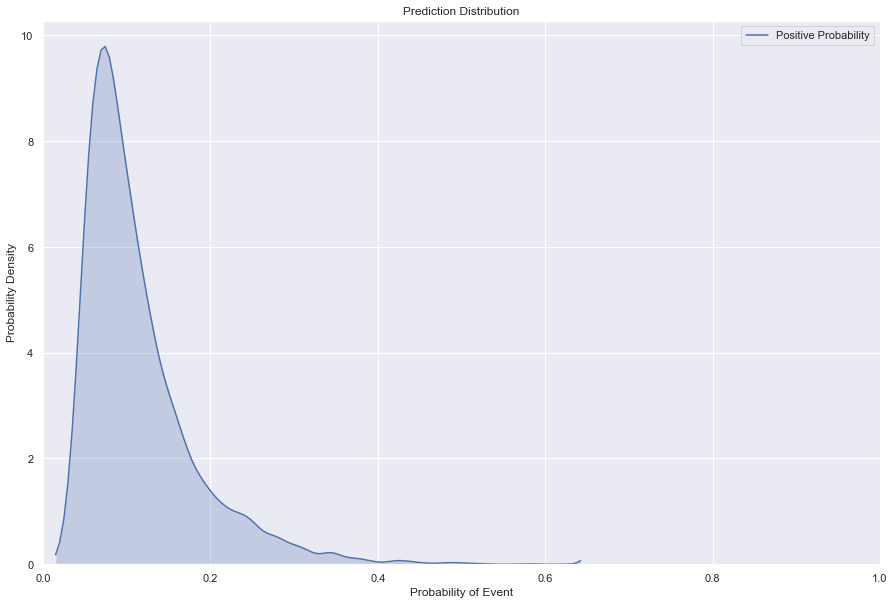

In [44]:
sns.set(color_codes=True)
sns.kdeplot(predictions.positive_probability, shade=True, cut=0,
            label='Positive Probability')
plt.xlim((0, 1))
plt.ylim((0, None))
plt.xlabel('Probability of Event')
plt.ylabel('Probability Density')
plt.title('Prediction Distribution')

## Advanced: Clustering on Prediction Explanations

In [45]:
# #####################################################################
# Generic method to do everything required to retrieve the scores and
# explanations for a given data set.
# #####################################################################
# proj      = project
# mod       = model
# pdate     = prediction data
# n_reasons = number of reasons (explanations)
#
def retrieve_prediction_explanations(proj, mod, pdata, n_reasons = 5):
    # UPLOAD THE DATASET
    dataset = proj.upload_dataset(pdata) # Returns an instance of [PredictionDataset]
    pred_job = mod.request_predictions(dataset.id)
    preds = pred_job.get_result_when_complete()
    # NOW WE NEED TO ENSURE THAT FEATURE IMPACT EXISTS FOR THAT MODEL
    try:
        impact_job = mod.request_feature_impact()
        impact_job.wait_for_completion(300)
    except dr.errors.JobAlreadyRequested:
        pass  # already computed
    # NOW ENSURE THAT THE PREDICTION EXPLANATIONS ARE COMPUTED 
    try:
        dr.PredictionExplanationsInitialization.get(proj.id, mod.id)
    except dr.errors.ClientError as e:
        assert e.status_code == 404  # haven't been computed
        init_job = dr.PredictionExplanationsInitialization.create(proj.id, mod.id)
        init_job.wait_for_completion()
    # RUN THE REASON CODE JOB
    rc_job = dr.PredictionExplanations.create(proj.id,
                               mod.id,
                               dataset.id,
                               max_explanations=n_reasons,
                               threshold_low=None,
                               threshold_high=None)
    rc = rc_job.get_result_when_complete(max_wait=1200)
    all_rows = rc.get_all_as_dataframe()
    return all_rows

In [47]:
exp = retrieve_prediction_explanations(project, best_w_race_model, 
                                       Readmission_filtered,
                                       n_reasons = 6)

In [48]:
# ######################################################################
# UTILITY FUNCTIONS FOR CLEAN RE_USABLE BEHAVIOUR - thanks to John Hawkins for this piece
# ######################################################################
def unlist(listOfLists):
    return [item for sublist in listOfLists for item in sublist]

def unique_elements(bigList):
    return reduce(lambda l, x: l.append(x) or l if x not in l else l, bigList, [])

# #############################################################
# TRANSFORMATION OF THE PREDICTION EXPLANATIONS INTO A SET OF 
# COLUMNS PER FEATURE WITH THE QUANTITATIVE PREDICTION STRENGTH 
# VALUE IN THE DATA CELL
# WE NEED TO KNOW THE PROJECT TYPE TO DETERMINE THE COLUMN NUMBER
# WHERE THE EXPLANATIONS START.
# #############################################################
def get_strength_per_feature_cols(proj, all_rows, n_reasons=5):
    colsToUse = []
    startPoint = 6
    if proj.target_type == 'Regression':
        startPoint = 2
    if proj.target_type == 'Binary':
        startPoint = 6
    j = startPoint
    for i in range(n_reasons):
        colsToUse.append(j) 
        colsToUse.append(j+4)
        j = j + 5 
    rc3 = all_rows.iloc[:, colsToUse]
    j = 0
    colsForNames = []
    for i in range(n_reasons):
        colsForNames.append(j) 
        j = j + 2 
    namesdf = rc3.iloc[:,colsForNames]
    allfeatures = [namesdf[i].unique().tolist() for i in namesdf.columns]
    nameslist = unique_elements(unlist(allfeatures))
    ####################################################################
    # CREATE A NEW DATAFRAME WITH ONE COLUMN PER POSSIBLE REASON CODE
    # INITIALISE TO ZERO AND THEN FILL WITH THE EXPLANATION STRENGTHS
    ####################################################################
    dfnew = pd.DataFrame(columns=nameslist)
    for j in range(len(rc3)):
        dfnew.loc[j] = [0 for n in range(len(nameslist))]
        for i in range(n_reasons):
            rcname = rc3.loc[j][i*2] 
            rcvalue = rc3.loc[j][i*2+1]
            dfnew.loc[j][rcname] = rcvalue    
    return dfnew    

In [49]:
flattened = get_strength_per_feature_cols(project, exp, n_reasons=6)

In [50]:
flattened

,discharge_disposition_id,A1Cresult,discharge_description,number_inpatient,diag_3_desc,diag_2,age,number_emergency,diag_2_desc,diag_3,...,medical_specialty,rosiglitazone,repaglinide,payer_code,admit_type_description,glyburide_metformin,glipizide,num_procedures,insulin,glyburide
0,0.18608,-0.154204,-0.0898584,-0.135679,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.107928,-0.168521,-0.05735,-0.138866,0,0,0,0,0,-0.082741,...,0,0,0,0,0,0,0,0,0,0
2,0.186641,0,0.386299,-0.105873,0,0,0,0,0,0.0927845,...,0,0,0,0,0,0,0,0,0,0
3,-0.125374,-0.174397,0,-0.168514,0,0,0,0,0.112148,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0694344,0,0,0.407942,0.191277,0,0,0.123716,0,0.0680332,...,0,0,0,0,0,0,0,0,0,0
5,0.198412,0,0.0789846,0.53475,0.0729837,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0.151318,-0.211643,0.393331,-0.097382,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0.186641,0,0,-0.102694,0,0,0,0,0,-0.082741,...,0,0,0,0,0,0,0,0,0,0
8,0.186641,0,0,-0.102992,0.0756683,0,0,0,0,0.0985044,...,0,0,0,0,0,0,0,0,0,0
9,-0.125374,-0.174397,-0.05735,-0.145109,0,0,0,0,0,0.0731343,...,0,0,0,0,0,0,0,0,0,0


In [53]:
import umap
import hdbscan
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(10,8)})

In [54]:
#Recommended settings for UMAP, but can use other dimensionality reduction techniques.  N_neighbors influences the density 
#requirement per cluster
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(flattened)

/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


In [55]:
print(flattened.shape)
print(clusterable_embedding.shape)

(20662, 29)
(20662, 2)


In [56]:
Readmission_filtered.head()

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,metformin-pioglitazone,change,diabetesMed,readmitted,admit_description,admit_type_description,discharge_description,diag_1_desc,diag_2_desc,diag_3_desc
0,Caucasian,Female,[70-80),?,6,25,7,2,?,InternalMedicine,...,No,No,No,False,Emergency Room,NaN,Not Mapped,Chronic passive congestion of liver,Acute pancreatitis,Adrenal cortical steroids causing adverse effe...
1,Caucasian,Female,[60-70),?,1,1,7,4,BC,?,...,No,No,Yes,False,Emergency Room,Emergency,Discharged to home,Coronary atherosclerosis of unspecified type o...,Diabetes mellitus without mention of complicat...,Malignant essential hypertension
2,AfricanAmerican,Female,[70-80),?,1,5,7,7,?,Nephrology,...,No,No,Yes,False,Emergency Room,Emergency,Discharged/transferred to another type of inpa...,"Respiratory abnormality, unspecified",Hyperosmolality and/or hypernatremia,Mitral valve stenosis and aortic valve stenosis
3,Caucasian,Female,[30-40),?,1,1,7,2,MC,?,...,No,Ch,Yes,False,Emergency Room,Emergency,Discharged to home,"Diabetes with ketoacidosis, type I [juvenile t...","Diabetes with ophthalmic manifestations, type ...",NaN
4,AfricanAmerican,Male,[60-70),?,6,6,17,5,?,Orthopedics-Reconstructive,...,No,No,Yes,False,NaN,NaN,Discharged/transferred to home with home healt...,"Closed dislocation of wrist, unspecified part",NaN,"Hypertensive chronic kidney disease, malignant..."


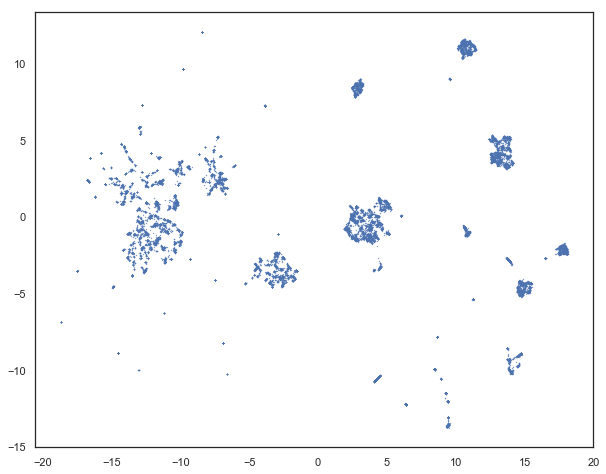

In [57]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1);

In [58]:
###Get cluster labels for your dataset
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(clusterable_embedding)

/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


In [59]:
##See how many clusters 
set(labels)

#NB - -1 is a cluster of "noise" for HDBSCAN and should not be viewed as an actual cluster

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


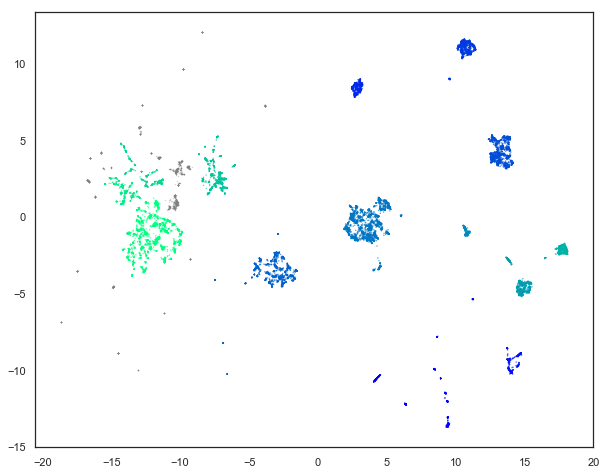

In [60]:
clustered = (labels >= 0)  ###  the -1 cluster is noise within HDBSCAN
plt.scatter(clusterable_embedding[~clustered, 0],
            clusterable_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(clusterable_embedding[clustered, 0],
            clusterable_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='winter');

## Advanced: Model Factory

What if we wanted to build models by Admission Type?


In [69]:
# A simple model factory: Four sub-models

admission_ids = ['Elective', 'Urgent', 'Other', 'Emergency']
Elective = Readmission_filtered.query('admit_type_description == "Elective"')
Urgent = Readmission_filtered.query('admit_type_description == "Urgent"')
Emergency = Readmission_filtered.query('admit_type_description == "Emergency"')
Other = Readmission_filtered.query('admit_type_description not in ["Elective", "Urgent", "Emergency"]')
dataset_list = [ Elective, Urgent, Other, Emergency ]

In [71]:
# Run projects
projects = list()
for i in range(4):
    projects.append(dr.Project.start(dataset_list[i],
                                     project_name=admission_ids[i],
                                     target="readmitted",
                                     worker_count=-1,
                                     autopilot_on=True))